## Main

### Training

In [1]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, set_seed
import evaluate
import torch
import os
import numpy as np
from tqdm import tqdm
from datasets import load_from_disk, DatasetDict
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score
import gc
from peft import get_peft_model, LoraConfig, TaskType

seed = 0
np.random.seed(seed)
torch.manual_seed(seed)
set_seed(seed)

lr = 5e-5
batch_size = 12
num_epochs = 1

model_name = 'meta-llama/Llama-2-7b-hf'
orig_tokenizer = AutoTokenizer.from_pretrained('EleutherAI/pythia-160m')
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token

peft_config = LoraConfig(
    r=16,
    lora_alpha=16,
    target_modules=["q_proj", "v_proj"],
    lora_dropout=0.05, 
    bias="none",
    modules_to_save=["score"],
    task_type=TaskType.SEQ_CLS,
)

path = '../../../gld/train-data-probes/data/12b'
dataset = load_from_disk(os.path.join(path, 'split_hf_token_dataset_vary_len_v2'))
id2label = {0: 'neg', 1: 'pos'}
label2id = {'neg': 0, 'pos': 1}
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2, id2label=id2label, label2id=label2id, low_cpu_mem_usage=True, device_map='auto')
# model.to('cuda')
model.config.pad_token_id = model.config.eos_token_id

lora_model = get_peft_model(model, peft_config)
lora_model.print_trainable_parameters()

ModuleNotFoundError: No module named 'evaluate'

In [2]:
# pad datasets

def preprocess(example): 
    return {'input_ids': tokenizer(orig_tokenizer.decode(example['input_ids']), return_tensors='pt')['input_ids'][0]}

dataset['train'] = dataset['train'].map(preprocess)
dataset['val'] = dataset['val'].map(preprocess)
dataset['test'] = dataset['test'].map(preprocess)

max_train_len = max([len(x['input_ids']) for x in dataset['train']])
max_val_len = max([len(x['input_ids']) for x in dataset['val']])
max_test_len = max([len(x['input_ids']) for x in dataset['test']])

def preprocess(examples, max_len): 
    curr_len = len(examples['input_ids'])
    if curr_len < max_len:
        examples['input_ids'] = examples['input_ids'] + [tokenizer.pad_token_id]*(max_len-curr_len)
    return examples

dataset['train'] = dataset['train'].map(lambda x: preprocess(x, max_train_len))
dataset['val'] = dataset['val'].map(lambda x: preprocess(x, max_val_len))
dataset['test'] = dataset['test'].map(lambda x: preprocess(x, max_test_len))

dataset

NameError: name 'dataset' is not defined

In [3]:
train_lens = [len(x['input_ids']) for x in dataset['train']]
val_lens = [len(x['input_ids']) for x in dataset['val']]
test_lens = [len(x['input_ids']) for x in dataset['test']]

assert len(set(train_lens)) == len(set(val_lens)) == len(set(test_lens)) == 1, (set(train_lens), set(val_lens), set(test_lens))

NameError: name 'dataset' is not defined

In [4]:
def tpr_at_fpr(probs, labels, target_fpr, left=0.5, right=1.0, max_steps=1000, thresh_tol=1e-6): 
    """
    Calculates the true positive rate at a given false positive rate. 
    Does up to max_steps steps of binary search, returns the best guess 
    that yields a false positive rate less than target_fpr
    
    probs: (n_examples, ) just prob on positive class
    labels: (n_examples, ) 0 or 1
    """
    assert len(probs) == len(labels)
    assert probs.shape == labels.shape
    assert probs.shape[0] > 0

    for _ in range(max_steps):
        mid = (left + right) / 2
        
        # calc fpr 
        preds = (probs > mid).astype(int)
        fp = np.logical_and(preds == 1, labels == 0).sum()
        tn = (labels == 0).sum()
        fpr = fp / tn if tn > 0 else 0

        if abs(fpr - target_fpr) < thresh_tol: 
            right = mid
            break
        elif fpr > target_fpr:
            left = mid
        else:
            right = mid
    
    # use right as threshold to ensure fpr <= target_fpr
    preds = (probs > right).astype(int)
    tp = np.logical_and(preds == 1, labels == 1).sum()
    fn = (labels == 1).sum()
    return tp / fn if fn > 0 else 0

In [5]:
loss_fn = torch.nn.CrossEntropyLoss()
data = {'val_loss': [], 'accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'AUC': [], 'tpr_01': [], 'tpr_001': [], 'tpr_0001': []}

def compute_metrics(eval_pred):
    
    logits, labels = eval_pred
    logits = np.array(logits) # (n_examples, n_classes)
    labels = np.array(labels) # (n_examples)

    preds = np.argmax(logits, axis=1)
    normalized_prob = np.exp(logits) / np.exp(logits).sum(axis=1, keepdims=True)
    positive_prob = normalized_prob[:, 1]
    acc = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    auc = roc_auc_score(labels, positive_prob)
    
    loss = loss_fn(torch.tensor(logits), torch.tensor(labels))

    # calculate tpr at fpr = 0.01, 0.001, and 0.0001
    tpr_01 = tpr_at_fpr(positive_prob, labels, 0.01)
    tpr_001 = tpr_at_fpr(positive_prob, labels, 0.001)
    tpr_0001 = tpr_at_fpr(positive_prob, labels, 0.0001)

    # log
    data['val_loss'].append(loss.item())
    data['accuracy'].append(acc)
    data['precision'].append(precision)
    data['recall'].append(recall)
    data['f1'].append(f1)
    data['AUC'].append(auc)
    data['tpr_01'].append(tpr_01)
    data['tpr_001'].append(tpr_001)
    data['tpr_0001'].append(tpr_0001)

    return {'val_loss': loss.item(), 'accuracy': acc, 'precision': precision, 'recall': recall, 'f1': f1, 'AUC': auc, 'tpr_01': tpr_01, 'tpr_001': tpr_001, 'tpr_0001': tpr_0001}

NameError: name 'torch' is not defined

In [6]:
targs = TrainingArguments(
    output_dir = os.path.join(path, 'finetuning/final-llama-on-pythia'),
    evaluation_strategy = 'steps',
    eval_steps=250,
    logging_strategy = 'steps',
    logging_steps=250,
    # save_strategy='epoch',
    learning_rate=lr,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=32,
    num_train_epochs=1,
    save_total_limit=10,
    load_best_model_at_end=True,
    metric_for_best_model='val_loss',
    weight_decay=0.01,
    report_to='none',
    seed=seed,
    eval_accumulation_steps=1,
    fp16=True,
)

trainer = Trainer(
    model=model,
    tokenizer=tokenizer,
    args=targs,
    train_dataset=dataset['train'],
    eval_dataset=dataset['val'], 
    compute_metrics=compute_metrics,
)

NameError: name 'os' is not defined

In [7]:
trainer.train()

NameError: name 'trainer' is not defined

In [8]:
model.save_pretrained(os.path.join(path, 'finetuning/final/llama-2-7b-on-pythia-12b-dataset'))

NameError: name 'model' is not defined

### Evaluation

In [9]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, set_seed
import evaluate
import torch
import os
import numpy as np
from tqdm import tqdm
from datasets import load_from_disk, DatasetDict, Dataset
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score
import gc
import sys
sys.path.append('..')
from utils import tpr_at_fpr

seed = 0
np.random.seed(seed)
torch.manual_seed(seed)
set_seed(seed)

os.environ["CUDA_VISIBLE_DEVICES"]="0"
torch.cuda.set_device(0)

model_name = 'EleutherAI/pythia-160m'
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token

path = '../../../gld/train-data-probes/data/12b'
dataset = load_from_disk(os.path.join(path, 'split_hf_token_dataset_vary_len_v2'))
generalization_datasets = load_from_disk(os.path.join(path, 'generalization_datasets_v2'))
id2label = {0: 'neg', 1: 'pos'}
label2id = {'neg': 0, 'pos': 1}
model = AutoModelForSequenceClassification.from_pretrained(os.path.join(path, 'finetuning/160m/model'), num_labels=2, id2label=id2label, label2id=label2id)
model.to('cuda')
model.config.pad_token_id = model.config.eos_token_id

ModuleNotFoundError: No module named 'evaluate'

In [10]:
# pad datasets

max_train_len = max([len(x['input_ids']) for x in dataset['train']])
max_val_len = max([len(x['input_ids']) for x in dataset['val']])
max_test_len = max([len(x['input_ids']) for x in dataset['test']])

def preprocess(examples, max_len): 
    curr_len = len(examples['input_ids'])
    if curr_len < max_train_len:
        examples['input_ids'] = examples['input_ids'] + [tokenizer.pad_token_id]*(max_len-curr_len)
    return examples

dataset['train'] = dataset['train'].map(lambda x: preprocess(x, max_train_len))
dataset['val'] = dataset['val'].map(lambda x: preprocess(x, max_val_len))
dataset['test'] = dataset['test'].map(lambda x: preprocess(x, max_test_len))

dataset

NameError: name 'dataset' is not defined

In [11]:
generalization_datasets['fuzzy_pos'] = generalization_datasets['fuzzy_pos'].map(lambda x: preprocess(x, max_test_len))

# had to do it manually for prefix for some reason
prefix_input_ids = generalization_datasets['prefix']['input_ids']
max_len = 319
for i in range(len(prefix_input_ids)):
    curr_len = len(prefix_input_ids[i])
    if curr_len < max_len:
        prefix_input_ids[i] = prefix_input_ids[i] + [tokenizer.pad_token_id]*(max_len-curr_len)

generalization_datasets['prefix'] = Dataset.from_dict({'input_ids': prefix_input_ids, 'labels': generalization_datasets['prefix']['labels']})

NameError: name 'generalization_datasets' is not defined

In [12]:
train_lens = [len(x['input_ids']) for x in dataset['train']]
val_lens = [len(x['input_ids']) for x in dataset['val']]
test_lens = [len(x['input_ids']) for x in dataset['test']]

print(set(train_lens), set(val_lens), set(test_lens))
assert set(train_lens) == set(val_lens) == set(test_lens)

for gen_dataset in generalization_datasets.values(): 
    gen_lens = [len(x['input_ids']) for x in gen_dataset]
    print(set(gen_lens))

NameError: name 'dataset' is not defined

In [13]:
loss_fn = torch.nn.CrossEntropyLoss()
# data = {'val_loss': [], 'accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'AUC': [], 'tpr_01': [], 'tpr_001': [], 'tpr_0001': []}

def compute_metrics(eval_pred, single_class=False): 
    
    logits, labels = eval_pred
    logits = np.array(logits[0]) # (n_examples, n_classes)
    labels = np.array(labels) # (n_examples)

    preds = np.argmax(logits, axis=1)
    normalized_prob = np.exp(logits) / np.exp(logits).sum(axis=1, keepdims=True)
    positive_prob = normalized_prob[:, 1]
    acc = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    if not single_class: 
        auc = roc_auc_score(labels, positive_prob)
    
    loss = loss_fn(torch.tensor(logits), torch.tensor(labels))

    # calculate tpr at fpr = 0.01, 0.001, and 0.0001
    tpr_01 = tpr_at_fpr(positive_prob, labels, 0.01)
    tpr_001 = tpr_at_fpr(positive_prob, labels, 0.001)
    tpr_0001 = tpr_at_fpr(positive_prob, labels, 0.0001)

    if single_class: 
        return {'val_loss': loss.item(), 'accuracy': acc, 'precision': precision, 'recall': recall, 'f1': f1, 'tpr_01': tpr_01, 'tpr_001': tpr_001, 'tpr_0001': tpr_0001}
    return {'val_loss': loss.item(), 'accuracy': acc, 'precision': precision, 'recall': recall, 'f1': f1, 'AUC': auc, 'tpr_01': tpr_01, 'tpr_001': tpr_001, 'tpr_0001': tpr_0001}

NameError: name 'torch' is not defined

In [14]:
targs = TrainingArguments(
            output_dir = os.path.join(path, 'finetuning/final'),
            evaluation_strategy = 'steps',
            eval_steps=1,
            logging_strategy = 'steps',
            logging_steps=1,
            save_strategy='epoch',
            learning_rate=2e-5,
            per_device_train_batch_size=32,
            per_device_eval_batch_size=64,
            num_train_epochs=1,
            save_total_limit=10,
            load_best_model_at_end=True,
            metric_for_best_model='val_loss',
            weight_decay=0.01,
            report_to='none',
            seed=seed,
            eval_accumulation_steps=1,
        )

trainer = Trainer(
            model=model,
            tokenizer=tokenizer,
            args=targs,
            train_dataset=dataset['train'],
            eval_dataset=dataset['test'],
            compute_metrics=compute_metrics,
        )

NameError: name 'os' is not defined

In [15]:
trainer.evaluate()

NameError: name 'trainer' is not defined

In [16]:
trainer = Trainer(
    model=model,
    tokenizer=tokenizer,
    args=targs,
    train_dataset=dataset['train'],
    eval_dataset=generalization_datasets['fuzzy_pos'],
    compute_metrics=lambda x: compute_metrics(x, single_class=True),
)

trainer.evaluate()

NameError: name 'model' is not defined

In [17]:
trainer = Trainer(
    model=model,
    tokenizer=tokenizer,
    args=targs,
    train_dataset=dataset['train'],
    eval_dataset=generalization_datasets['prefix'],
    compute_metrics=compute_metrics,
)

trainer.evaluate()

NameError: name 'model' is not defined

## Sample Efficiency

### Training

In [18]:
loss_fn = torch.nn.CrossEntropyLoss()
data = {'val_loss': [], 'accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'AUC': [], 'tpr_01': [], 'tpr_001': [], 'tpr_0001': []}
def compute_metrics(eval_pred):
    
    logits, labels = eval_pred
    logits = np.array(logits[0]) # (n_examples, n_classes)
    labels = np.array(labels) # (n_examples)

    preds = np.argmax(logits, axis=1)
    normalized_prob = np.exp(logits) / np.exp(logits).sum(axis=1, keepdims=True)
    positive_prob = normalized_prob[:, 1]
    acc = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    auc = roc_auc_score(labels, positive_prob)
    
    loss = loss_fn(torch.tensor(logits), torch.tensor(labels))

    # calculate tpr at fpr = 0.01, 0.001, and 0.0001
    tpr_01 = tpr_at_fpr(positive_prob, labels, 0.01)
    tpr_001 = tpr_at_fpr(positive_prob, labels, 0.001)
    tpr_0001 = tpr_at_fpr(positive_prob, labels, 0.0001)

    # log
    data['val_loss'].append(loss.item())
    data['accuracy'].append(acc)
    data['precision'].append(precision)
    data['recall'].append(recall)
    data['f1'].append(f1)
    data['AUC'].append(auc)
    data['tpr_01'].append(tpr_01)
    data['tpr_001'].append(tpr_001)
    data['tpr_0001'].append(tpr_0001)

    return {'val_loss': loss.item(), 'accuracy': acc, 'precision': precision, 'recall': recall, 'f1': f1, 'AUC': auc, 'tpr_01': tpr_01, 'tpr_001': tpr_001, 'tpr_0001': tpr_0001}

NameError: name 'torch' is not defined

In [19]:
targs = TrainingArguments(
            output_dir = os.path.join(path, 'finetuning/eval'),
            evaluation_strategy = 'steps',
            eval_steps=1, 
            logging_strategy = 'steps',
            logging_steps=1,
            save_strategy='steps',
            learning_rate=lr,
            per_device_train_batch_size=batch_size,
            per_device_eval_batch_size=256,
            num_train_epochs=1,
            save_total_limit=2,
            load_best_model_at_end=True,
            metric_for_best_model='val_loss',
            weight_decay=0.01,
            report_to='wandb',
            seed=seed,
        )

trainer = Trainer(
    model=model,
    tokenizer=tokenizer,
    args=targs,
    train_dataset=dataset['train'],
    eval_dataset=dataset['val'],
    compute_metrics=compute_metrics,
)

NameError: name 'os' is not defined

In [20]:
trainer.train()

NameError: name 'trainer' is not defined

In [21]:
import pickle

with open('sample_efficiency.pkl', 'wb') as f:
    pickle.dump(data, f)

NameError: name 'data' is not defined

### Evaluation

In [22]:
import pickle 

with open('sample_efficiency.pkl', 'rb') as f:
    data = pickle.load(f)

xs = [32*i for i in range(len(data['accuracy']))]
idxs = [i for i in xs if i & (i-1) == 0]

EOFError: Ran out of input

NameError: name 'data' is not defined

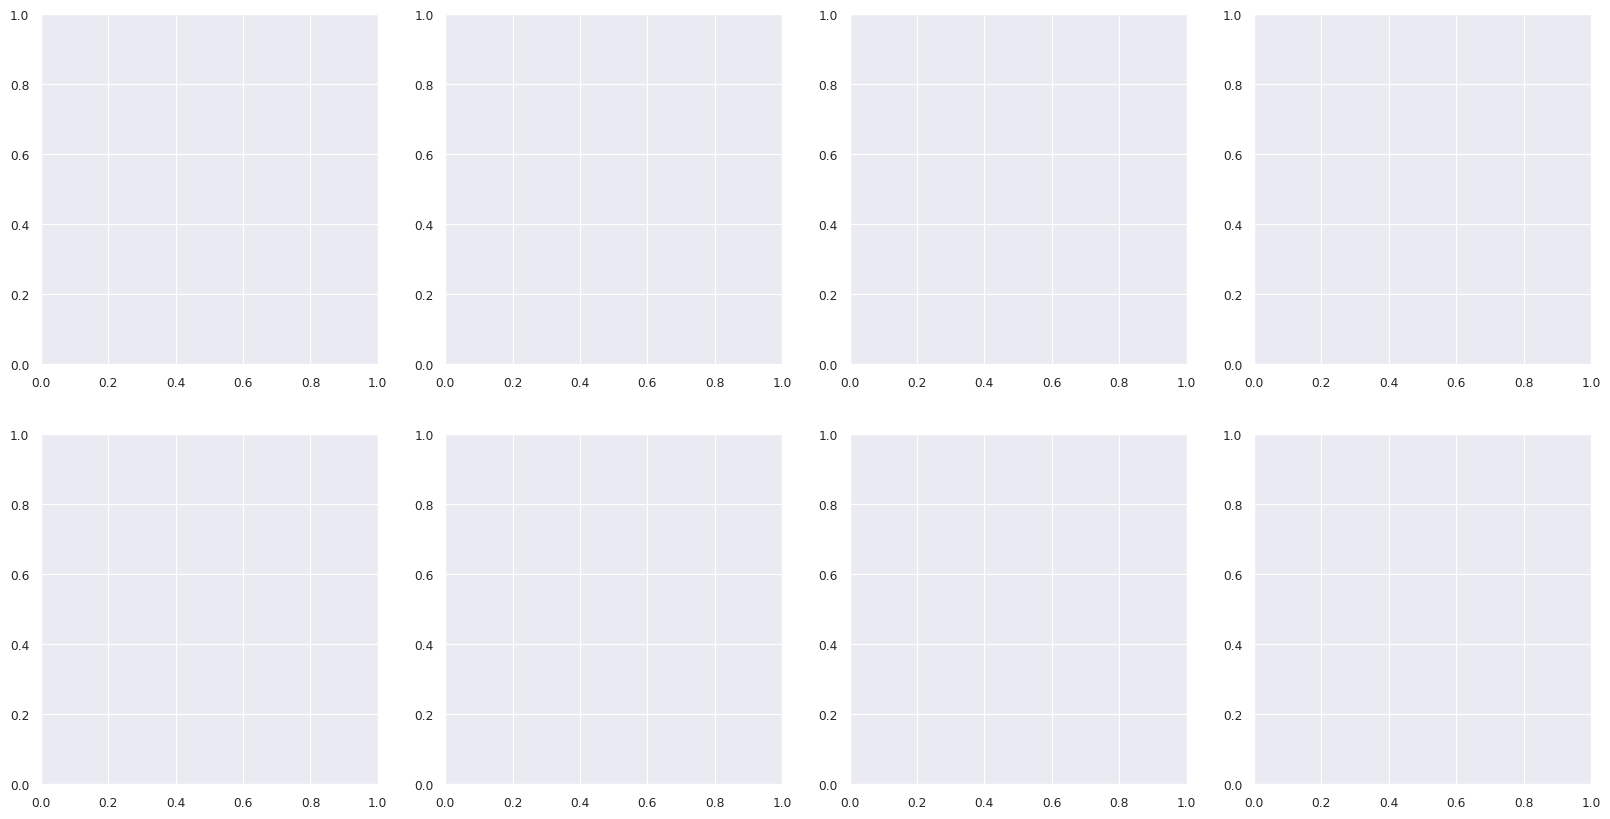

In [23]:
import matplotlib.pyplot as plt 
import seaborn as sns 

sns.set_style('darkgrid')
sns.set_context('paper')

# create 4 x 2 subplots
fig, axes = plt.subplots(2,4, figsize=(20,10))
axes = axes.flatten()

for i, key in enumerate(data.keys()):
    if key == 'val_loss':
        continue
    ax = axes[i-1]
    ax.plot([data[key][x//32] for x in idxs], label=key)
    ax.set_xticks(range(9))
    ax.set_xticklabels(idxs)
     
    ax.set_title(key)
    ax.title.set_fontsize(16)

plt.suptitle("Text Classifier Sample Efficiency", fontsize=20)
plt.tight_layout()
plt.show()